# Modelo Preditivo para Análise da Estabilidade Fiscal
## 1. Setup & Carregamento de Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

# Configurações de visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# Carregamento dos dados
diretorio_raiz_projeto = '/home/douglas-souza/PycharmProjects/Fiscal_Stability_Prediction'
caminho_dados = os.path.join(diretorio_raiz_projeto, 'data', '04_features', 'featured_data.csv')
df = pd.read_csv(caminho_dados)

# Correção de valores infinitos
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print(f"Dataset carregado com sucesso de: {caminho_dados}")
print(f"Dimensões do dataset após correção: {df.shape}")
display(df.head())

Dataset carregado com sucesso de: /home/douglas-souza/PycharmProjects/Fiscal_Stability_Prediction/data/04_features/featured_data.csv
Dimensões do dataset após correção: (1065, 28)


,country_name,country_id,year,Inflation (CPI %),GDP (Current USD),GDP per Capita (Current USD),Unemployment Rate (%),"Interest Rate (Real, %)","Inflation (GDP Deflator, %)",GDP Growth (% Annual),...,GDP Growth (% Annual)_lag1,Inflation (CPI %)_lag1,"Interest Rate (Real, %)_lag1",Current Account Balance (% GDP)_lag1,GDP Growth (% Annual)_rolling_mean_3y,GDP Growth (% Annual)_rolling_std_3y,Inflation (CPI %)_rolling_mean_3y,Inflation (CPI %)_rolling_std_3y,GDP Growth (% Annual)_pct_change_1y,Inflation (CPI %)_pct_change_1y
0,Albania,al,2011,3.428071,1.289076e+10,4437.141161,13.481,9.888462,2.314744,2.545406,...,3.706938,3.627101,7.971037,-11.365866,3.126172,0.821327,3.527586,0.140735,-0.313340,-0.054873
1,Albania,al,2012,2.031593,1.231983e+10,4247.631343,13.376,9.736112,1.042715,1.417243,...,2.545406,3.428071,9.888462,-12.933101,2.556529,1.144888,3.028922,0.869426,-0.443215,-0.407366
2,Albania,al,2013,1.937621,1.277622e+10,4413.063383,15.866,9.510397,0.288746,1.002018,...,1.417243,2.031593,9.736112,-10.200176,1.654889,0.798667,2.465762,0.834708,-0.292981,-0.046255
3,Albania,al,2014,1.625865,1.322815e+10,4578.633208,18.055,6.324558,1.549917,1.774449,...,1.002018,1.937621,9.510397,-9.274188,1.397903,0.386579,1.865026,0.212382,0.770876,-0.160896
4,Albania,al,2015,3.501208,1.138685e+10,3952.803574,17.193,7.272492,0.563991,2.218726,...,1.774449,1.625865,6.324558,-10.775399,1.665064,0.615686,2.354898,1.004897,0.250375,1.153443


## 2. Análise Exploratória de Dados (EDA)

Estatísticas descritivas das colunas numéricas:


,year,Inflation (CPI %),GDP (Current USD),GDP per Capita (Current USD),Unemployment Rate (%),"Interest Rate (Real, %)","Inflation (GDP Deflator, %)",GDP Growth (% Annual),Current Account Balance (% GDP),Government Expense (% of GDP),...,GDP Growth (% Annual)_lag1,Inflation (CPI %)_lag1,"Interest Rate (Real, %)_lag1",Current Account Balance (% GDP)_lag1,GDP Growth (% Annual)_rolling_mean_3y,GDP Growth (% Annual)_rolling_std_3y,Inflation (CPI %)_rolling_mean_3y,Inflation (CPI %)_rolling_std_3y,GDP Growth (% Annual)_pct_change_1y,Inflation (CPI %)_pct_change_1y
count,1065.00,1065.00,1.065000e+03,1065.00,1065.00,1065.00,1065.00,1065.00,1065.00,1065.00,...,1065.00,1065.00,1065.00,1065.00,1065.00,1065.00,1065.00,1065.00,1065.00,1065.00
mean,2017.00,4.80,6.544121e+11,17095.34,7.80,5.80,4.92,2.73,-3.03,28.07,...,2.86,4.53,5.71,-3.15,2.82,2.85,4.48,2.04,-0.86,0.11
std,3.74,6.08,2.374852e+12,20563.68,5.89,6.36,7.40,4.50,9.50,10.18,...,4.58,5.75,6.33,9.35,2.86,3.21,4.80,3.05,11.09,4.78
min,2011.00,-3.23,1.723000e+08,343.02,0.25,-33.49,-28.76,-32.91,-60.00,6.12,...,-32.91,-3.23,-33.49,-60.00,-9.69,0.01,-1.32,0.00,-222.81,-51.52
25%,2014.00,1.48,1.261580e+10,3677.91,3.99,2.78,1.32,1.14,-6.52,20.87,...,1.20,1.40,2.83,-6.83,1.26,0.83,1.59,0.66,-0.93,-0.45
50%,2017.00,3.40,5.423227e+10,7363.27,5.90,5.19,3.28,2.83,-2.46,26.67,...,2.90,3.24,5.19,-2.65,2.68,1.85,3.40,1.25,-0.29,-0.04
75%,2020.00,6.33,3.634938e+11,22141.87,9.66,7.51,6.57,4.84,1.38,33.76,...,5.05,6.09,7.47,1.29,4.30,3.73,5.94,2.24,0.17,0.43
max,2023.00,72.31,2.772071e+13,106194.76,35.36,57.63,96.04,37.51,37.34,66.46,...,37.51,72.31,57.63,37.34,18.69,35.83,48.59,32.75,148.02,85.64


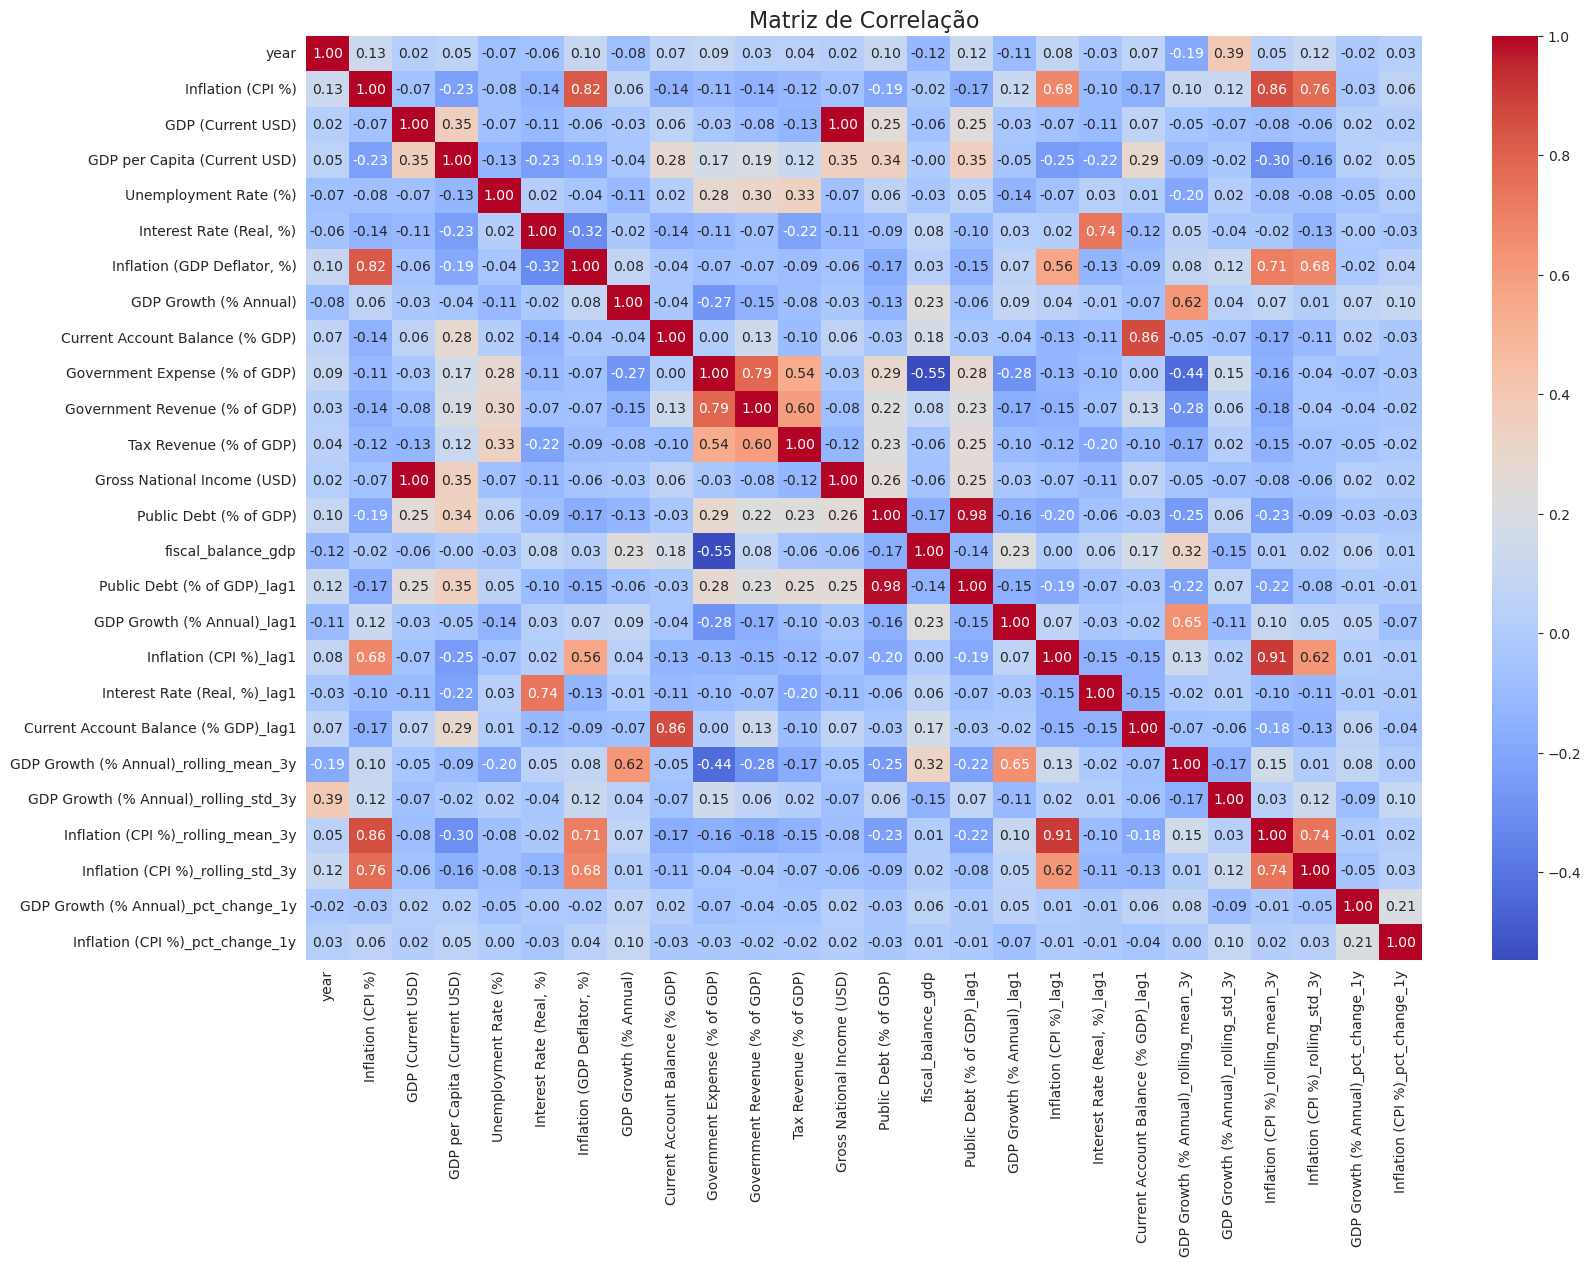

In [2]:
print("Estatísticas descritivas das colunas numéricas:")
display(df.describe().round(2))

# Matriz de correlação
plt.figure(figsize=(18, 12))
numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlação', fontsize=16)
plt.show()

## 3. Pré-processamento e Pipeline de Modelagem

In [3]:
TARGET = 'Public Debt (% of GDP)'
FEATURES = [col for col in df.columns if col not in [TARGET, 'country_name', 'country_id']]
X = df[FEATURES]
y = df[TARGET]

ano_divisao = 2021
X_train = X[X['year'] < ano_divisao].drop('year', axis=1)
y_train = y[X['year'] < ano_divisao]
X_test = X[X['year'] >= ano_divisao].drop('year', axis=1)
y_test = y[X['year'] >= ano_divisao]

## 4. Otimização e Treinamento do Modelo Final

In [4]:
pipeline_rf = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=42))])
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_leaf': [1, 2, 4]
}
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")

Melhores parâmetros encontrados: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__n_estimators': 100}


## 5. Avaliação Final e Análise de Erros

R²: 0.9578, MAE: 5.4382, RMSE: 8.0668


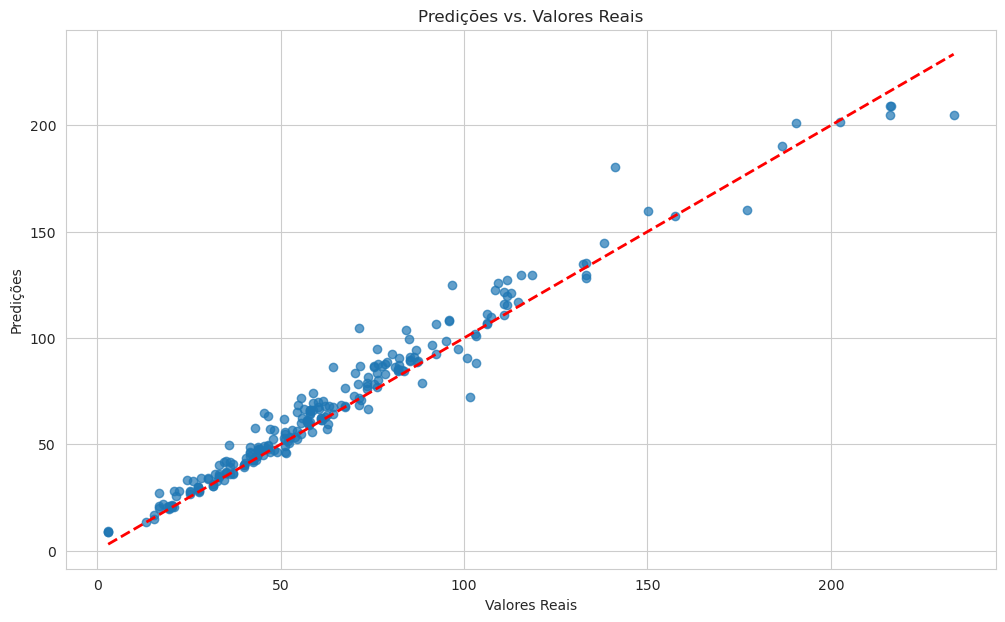

In [5]:
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Visualização: Predições vs. Valores Reais
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.title('Predições vs. Valores Reais')
plt.xlabel('Valores Reais')
plt.ylabel('Predições')
plt.show()

## 6. Análise de Interpretabilidade com SHAP

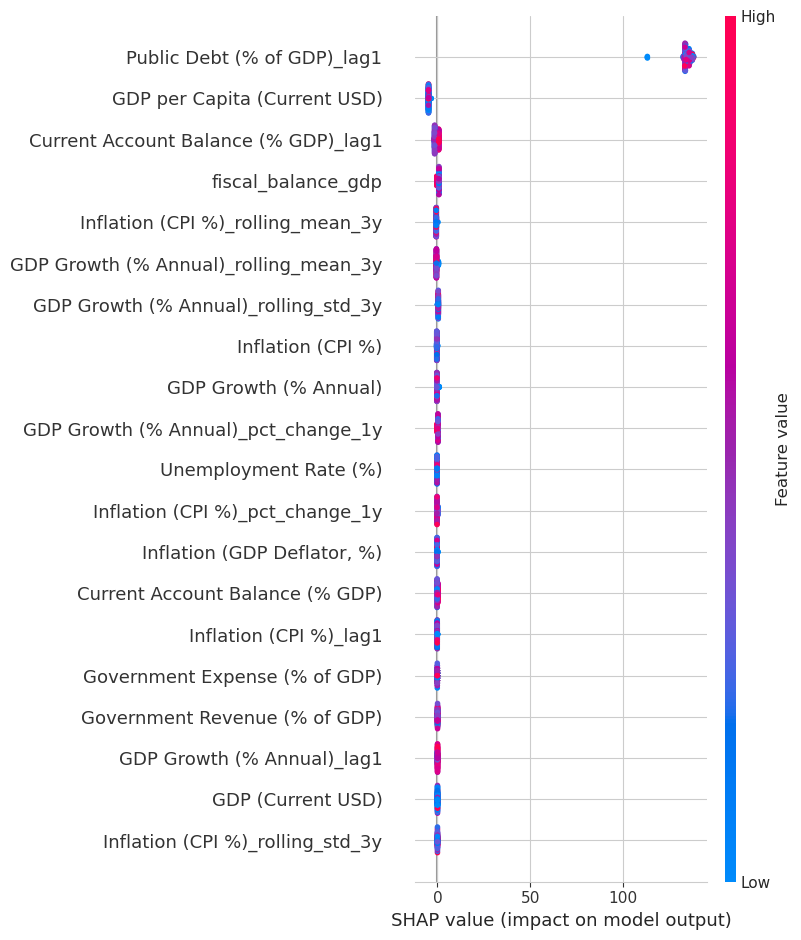

In [6]:
import shap
explainer = shap.TreeExplainer(best_model.named_steps['model'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

## 7. Simulação de Cenários de Estresse

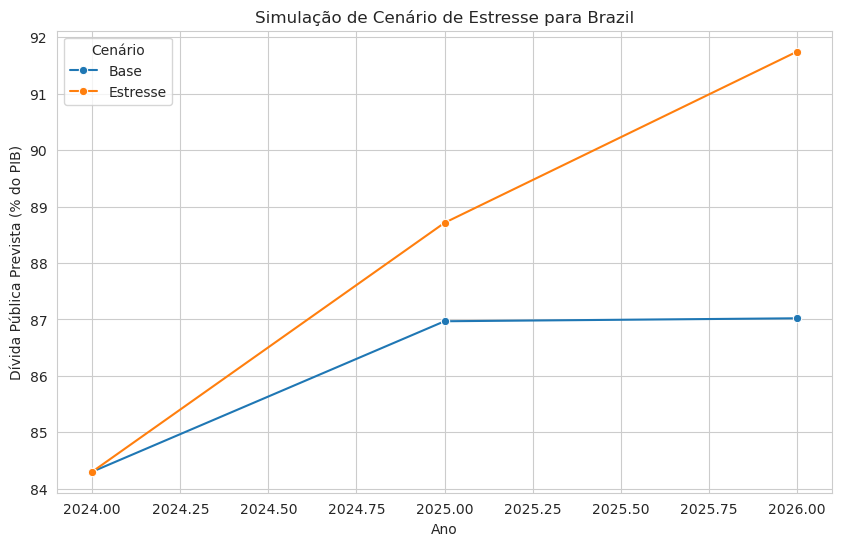

In [7]:
def simular_cenario_estresse(pais, modelo, df_historico, anos_simulacao, choque_gdp):
    # Função para recalcular features para um novo ano
    def proximo_ano_features(df_ano_anterior, pred_divida, choque_gdp):
        novo_ano = df_ano_anterior.copy()
        novo_ano['year'] += 1
        novo_ano['Public Debt (% of GDP)_lag1'] = pred_divida
        novo_ano['GDP Growth (% Annual)_lag1'] = novo_ano['GDP Growth (% Annual)']
        novo_ano['Inflation (CPI %)_lag1'] = novo_ano['Inflation (CPI %)']
        novo_ano['GDP Growth (% Annual)'] = choque_gdp
        return novo_ano

    # Isolar dados e preparar para simulação
    dados_pais = df_historico[df_historico['country_name'] == pais].sort_values(by='year')
    ultimo_ano_dados = dados_pais.iloc[-1:]
    
    # Simular cenários
    resultados = []
    cenarios = {'Base': ultimo_ano_dados['GDP Growth (% Annual)'].values[0], 'Estresse': choque_gdp}
    for nome_cenario, valor_choque in cenarios.items():
        df_sim = ultimo_ano_dados.copy()
        for _ in range(anos_simulacao):
            pred = modelo.predict(df_sim[X_train.columns])[0]
            resultados.append([pais, df_sim['year'].values[0] + 1, nome_cenario, pred])
            df_sim = proximo_ano_features(df_sim, pred, valor_choque)

    # Plotar resultados
    df_resultados = pd.DataFrame(resultados, columns=['País', 'Ano', 'Cenário', 'Dívida (% PIB)'])
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_resultados, x='Ano', y='Dívida (% PIB)', hue='Cenário', marker='o')
    plt.title(f'Simulação de Cenário de Estresse para {pais}')
    plt.ylabel('Dívida Pública Prevista (% do PIB)')
    plt.grid(True)
    plt.show()

# Executar simulação para o Brasil com um choque de -2% no PIB
simular_cenario_estresse('Brazil', best_model, df, 3, -2.0)